# Dataset과 DataLoader
- 수업 들을 때마다 헷갈리고 어렵고 작성하는데 어려움을 겪어서 튜토리얼로 다시 봅니다.
- Dataset : 샘플과 정답(label)을 저장한다.
- DataLoader : Datset을 샘플에 쉽게 접근할 수 있또록 순회 가능한(iterable) 객체로 감싼다.

torchvision에서 데이터셋을 불러오는 예제를 통해 살펴보자 FashionMNIST는 이미지 데이터셋 중 하나로, 6만개의 학습 예제와 1만개의 시험 예제로 이루어져 있다. 각 예제는 흑백(grayscale)의 28x28 이미지와 10개의 분류(class) 중 하나인 정답(label)으로 구성되어 있다. 우리가 사용할 매개변수는 아래와 같다.
- root
  - 학습 / 시험 데이터가 저장되는 경로
- train
  - 학습용 또는 시험용 데이터셋 여부를 지정
- download=True
  - root에 데이터가 없는 경우 인터넷을 통해 다운로드 받겠다
- transform, target_transform
  - 특징(feature)과 정답(label)에 변형(transform)을 지정

In [1]:
# 필요한 라이브러리 불러오기
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# 훈련, 시험용 데이터 불러오기
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



데이터셋을 순회하고 시각화해보자!
- Dataset에 우리는 list처럼 직접 접근(index)할 수 있다.
- training_data[index], matplotlib을 사용해 학습 데이터의 일부를 시각화 해볼 것

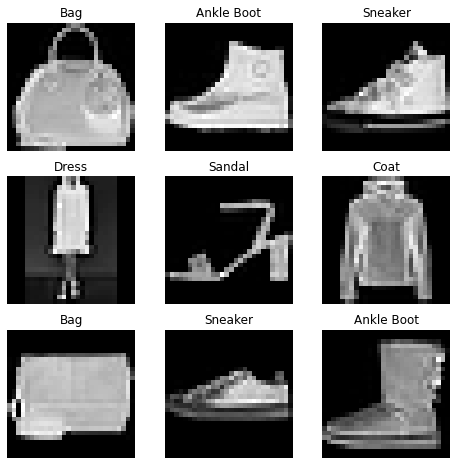

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

# 그리기 구간
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1) :
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

사용자 정의 Dataset 클래스는 반드시 3개의 함수를 구현해야 한다. __init__, __len__, __getitem__ 이 그것으로, 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file이라는 csv 파일에 별도로 저장된다.

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset) :
    # __init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행된다.
    # 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두가지 변형(transform)을 초기화한다.
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None) :
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    # __getitem__ 함수는 주어진 인덱스(idx)에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.
    # 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고,
    # self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환한다.
    def __getitem__(self, image) :
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform :
            image = self.transform(image)
        if self.target_transform :
            label = self.target_transform(label)
        return image, label

    # __len__ 함수는 데이터셋의 샘플 개수를 반환한다.
    def __len__(self) :
        return len(self.img_labels)

Dataset은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다. 모델을 학습시킬 때, 일반적으로 샘플을 mini batch로 전달하고 매 epoch마다 데이터를 다시 섞어서 과적합(overfitting)을 막고, Python의 multiprocessing을 사용해서 데이터 검색 속도를 높여준다.
- DataLoader는 간단한 API로 이런 복잡한 과정들을 추상화한 순회 가능한(iterable) 객체이다.

In [7]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다. 각 순회(iteration, batch_size=64의 feature, label을 포함하는)는 train_feature, train_labels의 묶음(batch)을 반환한다. shuffle=True로 지정했기에 모든 배치를 순회한 뒤 데이터가 섞인다.

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


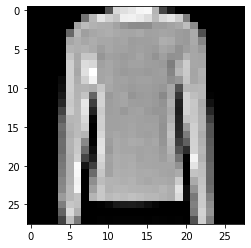

Label : 2


In [8]:
# 이미지와 정답(label)을 표시하자
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Labels batch shape : {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label : {label}")